# Image Similarity Search with CLIP

In this notebook, you will:

1. **Load** the CLIP embeddings computed in Notebook 03
2. **Select or upload** a query image
3. **Find** museum artworks that are visually similar to your image
4. **Explore** how CLIP understands visual similarity

---

## Text Search vs. Image Search

| | Text Search (Notebook 03) | Image Search (this notebook) |
|--|--------------------------|------------------------------|
| **Query** | `"a river landscape"` | 🖼️ any image file |
| **Encoded by** | CLIP text encoder | CLIP image encoder |
| **Finds** | images matching the description | images with similar visual content |
| **Use case** | explore by concept | "find more like this" |

Both use the same embedding space — the query vector just comes from a different encoder.


---

## Part 1: Setup

In [10]:
import json
from pathlib import Path

import numpy as np
from PIL import Image as PILImage
from IPython.display import display
import ipywidgets as widgets

try:
    import torch
    import clip
    CLIP_AVAILABLE = True
    print("✓ CLIP loaded!")
except ImportError:
    CLIP_AVAILABLE = False
    print("❌ CLIP not installed — pip install git+https://github.com/openai/CLIP.git torch torchvision")

if CLIP_AVAILABLE:
    if torch.cuda.is_available():
        DEVICE = 'cuda'
        print(f"✓ GPU: {torch.cuda.get_device_name(0)}")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        DEVICE = 'mps'
        print("✓ Apple Silicon GPU (MPS)")
    else:
        DEVICE = 'cpu'
        print("ℹ️  CPU mode")


✓ CLIP loaded!
✓ GPU: NVIDIA RTX A1000 6GB Laptop GPU


In [11]:
CURRENT_DIR  = Path.cwd()
PROJECT_ROOT = CURRENT_DIR.parent
DATA_DIR     = PROJECT_ROOT / "data"

# ============================================================
# CONFIGURATION — must match Notebooks 02 & 03!
# ============================================================

COLLECTION_NAME = "Museum of Gothenburg"
THEME           = "art"
SEARCH_KEYWORD  = None
MODEL_NAME      = "ViT-B/32"

# ============================================================

_parts = [COLLECTION_NAME.replace(' ', '_')]
if THEME:          _parts.append(THEME)
if SEARCH_KEYWORD: _parts.append(SEARCH_KEYWORD)
_folder = "_".join(_parts)

COLLECTION_IMAGES_DIR      = DATA_DIR / "images"     / _folder
COLLECTION_EMBEDDINGS_FILE = DATA_DIR / "embeddings" / _folder / f"{_folder}_clip_embeddings.npz"
CLIP_MODEL_DIR             = PROJECT_ROOT / "models" / "CLIP"

print(f"Images     : {COLLECTION_IMAGES_DIR}")
print(f"Embeddings : {COLLECTION_EMBEDDINGS_FILE}")
print(f"Exists     : {COLLECTION_EMBEDDINGS_FILE.exists()}")


Images     : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum_of_Gothenburg_art
Embeddings : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum_of_Gothenburg_art/Museum_of_Gothenburg_art_clip_embeddings.npz
Exists     : True


---

## Part 2: Load Model and Embeddings

In [12]:
if CLIP_AVAILABLE:
    print(f"Loading '{MODEL_NAME}' from {CLIP_MODEL_DIR}...")
    model, preprocess = clip.load(MODEL_NAME, device=DEVICE,
                                  download_root=str(CLIP_MODEL_DIR))
    model.eval()
    print(f"✓ Model ready on {DEVICE}")


Loading 'ViT-B/32' from /home/lauhp/000_PHD/000_003_Code/DH-Workshop/models/CLIP...
✓ Model ready on cuda


In [13]:
# Scan data/embeddings/ for collections that have computed embeddings
_emb_root = DATA_DIR / "embeddings"
_available = sorted([
    d.name for d in _emb_root.iterdir()
    if d.is_dir() and any(d.glob("*.npz"))
]) if _emb_root.exists() else []

if not _available:
    print("⚠️  No embeddings found in data/embeddings/")
    print("   Run Notebook 03 first to compute embeddings.")
    collection_selector = None
else:
    _default = _folder if _folder in _available else _available[0]

    collection_selector = widgets.Dropdown(
        options=_available,
        value=_default,
        description="Collection:",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="550px"),
    )

    _info = widgets.HTML(value="")

    def _update_info(change=None):
        sel     = collection_selector.value
        npz     = next((_emb_root / sel).glob("*.npz"), None)
        img_dir = DATA_DIR / "images" / sel
        n_emb   = ""
        if npz:
            try:
                d = __import__("numpy").load(npz, allow_pickle=True)
                n_emb = f"{len(d['filenames'])} embeddings"
            except Exception:
                n_emb = "embeddings file unreadable"
        n_img = len(list(img_dir.glob("*.jpg"))) if img_dir.exists() else 0
        _info.value = (
            f"<span style='color:grey'>{n_emb}"
            + (f" · {n_img} images locally" if n_img else " · images not downloaded")
            + "</span>"
        )

    collection_selector.observe(lambda c: _update_info(c), names="value")
    _update_info()

    display(widgets.VBox([collection_selector, _info]))
    print("Select a collection, then run the next cell to load its embeddings.")


Select a collection, then run the next cell to load its embeddings.


In [14]:
# Resolve paths from the dropdown above (falls back to paths cell if widget not shown)
_sel = collection_selector.value if collection_selector else _folder

COLLECTION_IMAGES_DIR      = DATA_DIR / "images"     / _sel
COLLECTION_EMBEDDINGS_FILE = next((DATA_DIR / "embeddings" / _sel).glob("*.npz"), None)

print(f"Collection : {_sel}")
print(f"Images     : {COLLECTION_IMAGES_DIR}")
print(f"Embeddings : {COLLECTION_EMBEDDINGS_FILE}")
print()

if COLLECTION_EMBEDDINGS_FILE and COLLECTION_EMBEDDINGS_FILE.exists():
    data = np.load(COLLECTION_EMBEDDINGS_FILE, allow_pickle=True)
    image_embeddings = torch.tensor(data['embeddings'], dtype=torch.float32).to(DEVICE)
    image_filenames  = data['filenames']
    print(f"✓ Loaded {len(image_filenames)} embeddings  {image_embeddings.shape}")
else:
    image_embeddings = None
    image_filenames  = None
    print("⚠️  No embeddings found — run Notebook 03 first.")

Collection : Museum of Gothenburg
Images     : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/images/Museum of Gothenburg
Embeddings : /home/lauhp/000_PHD/000_003_Code/DH-Workshop/data/embeddings/Museum of Gothenburg/Museum of Gothenburg_clip_embeddings.npz

✓ Loaded 1104 embeddings  torch.Size([1104, 512])


---

## Part 3: Choose a Query Image

You can use **any image** as your query — a painting, a photograph, even a smartphone photo.
CLIP encodes it into the same 512-dim space as the collection images and finds the closest matches.

### Option A — Upload a file (works in Colab & JupyterLab)


In [44]:
# Option A: upload from your computer
upload = widgets.FileUpload(accept='image/*', multiple=False)
display(upload)
print("Click 'Upload' and select an image file, then run the next cell.")


FileUpload(value=(), accept='image/*', description='Upload')

Click 'Upload' and select an image file, then run the next cell.


✓ Loaded: IMG_6646.JPG  (6000×4000)


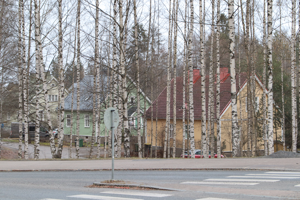

In [45]:
import io

# Run this after uploading a file above
if upload.value:
    file_info = upload.value[0]          # ipywidgets 8+: tuple of dicts
    name      = file_info['name']
    img_bytes = file_info['content']
    query_image = PILImage.open(io.BytesIO(img_bytes)).convert('RGB')
    print(f"✓ Loaded: {name}  ({query_image.size[0]}×{query_image.size[1]})")
    display(query_image.resize((300, int(300 * query_image.size[1] / query_image.size[0]))))
else:
    query_image = None
    print("No file uploaded yet.")

---

## Part 4: Find Similar Images

In [46]:
def image_similarity_search(query_img, top_k=10, exclude_self=True):
    """
    Find images in the collection most similar to query_img.

    Parameters:
        query_img:    PIL Image to use as the query
        top_k:        Number of results
        exclude_self: If True, skip the exact query image (useful for Option B)

    Returns:
        List of (filename, similarity_score) tuples
    """
    if image_embeddings is None:
        print("❌ No embeddings — run the load cell above")
        return []

    # Encode the query image with CLIP
    with torch.no_grad():
        tensor    = preprocess(query_img).unsqueeze(0).to(DEVICE)
        query_emb = model.encode_image(tensor).float()
        query_emb = query_emb / query_emb.norm(dim=-1, keepdim=True)

    # Dot product against all collection embeddings
    sims = (image_embeddings @ query_emb.T).squeeze()

    # Sort and take top-k
    top_idx = sims.argsort(descending=True)
    results = []
    for idx in top_idx:
        fname = str(image_filenames[idx.item()])
        score = sims[idx].item()
        if exclude_self and score > 0.9999:
            continue          # skip near-identical match (the image itself)
        results.append((fname, score))
        if len(results) >= top_k:
            break

    return results


if CLIP_AVAILABLE and image_embeddings is not None and query_image is not None:
    print("🔍 Searching for similar images...")
    similar = image_similarity_search(query_image, top_k=10)

    print(f"\nTop {len(similar)} most similar images:\n")
    for i, (fname, score) in enumerate(similar, 1):
        print(f"{i:2}. {score:.4f}  {Path(fname).name[:60]}")
else:
    print("❌ Make sure CLIP is loaded, embeddings are loaded, and a query image is selected.")
    similar = []


🔍 Searching for similar images...

Top 10 most similar images:

 1. 0.6991  _91674_GSM_delobjekt_487121_bilder målning akvarell.jpg
 2. 0.6818  _91674_GSM_delobjekt_487111_tavla målning bilder akvarell.jp
 3. 0.6734  _91668_GSM_objekt_388707_målning bilder tavla.jpg
 4. 0.6618  _91674_GSM_delobjekt_424402_akvarell tavla målning bilder.jp
 5. 0.6584  _91668_GSM_objekt_317403_bilder tavla akvarell målning.jpg
 6. 0.6561  _91674_GSM_delobjekt_3099331_teckning målning.jpg
 7. 0.6560  _91674_GSM_delobjekt_487148_bilder tavla målning akvarell.jp
 8. 0.6523  _91674_GSM_delobjekt_415852_tavla akvarell bilder målning.jp
 9. 0.6492  _91674_GSM_delobjekt_374465_teckning målning ghmd10085.jpg
10. 0.6489  _91674_GSM_delobjekt_487132_målning bilder tavla akvarell.jp



Similarity: 0.6991  |  _91674_GSM_delobjekt_487121_bilder målning akvarell.jpg


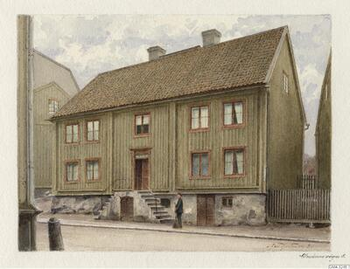


Similarity: 0.6818  |  _91674_GSM_delobjekt_487111_tavla målning bilder akvarell.jp


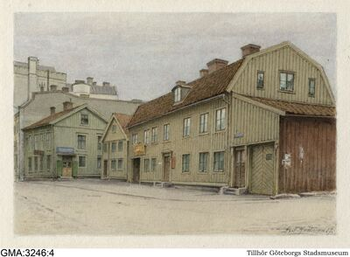


Similarity: 0.6734  |  _91668_GSM_objekt_388707_målning bilder tavla.jpg


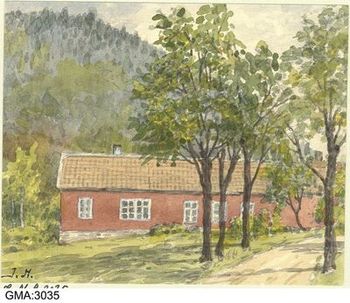


Similarity: 0.6618  |  _91674_GSM_delobjekt_424402_akvarell tavla målning bilder.jp


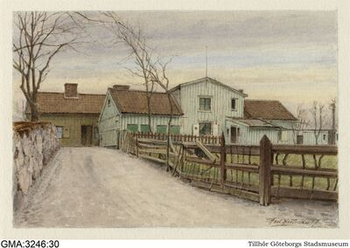


Similarity: 0.6584  |  _91668_GSM_objekt_317403_bilder tavla akvarell målning.jpg


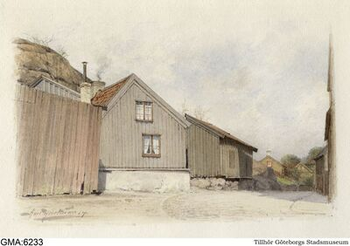

In [47]:
# Display the most similar images
def show_similar(results, max_show=5):
    for fname, score in results[:max_show]:
        img_path = COLLECTION_IMAGES_DIR / Path(fname).name
        print(f"\nSimilarity: {score:.4f}  |  {Path(fname).name[:60]}")
        if img_path.exists():
            img = PILImage.open(img_path)
            ratio = min(350 / img.width, 350 / img.height)
            if ratio < 1:
                img = img.resize((int(img.width*ratio), int(img.height*ratio)),
                                 PILImage.Resampling.LANCZOS)
            display(img)
        else:
            print("  [file not found locally]")

if similar:
    show_similar(similar, max_show=5)


---

## Part 5: Explore

- Try **different query images** — what makes two artworks "similar" to CLIP?
- Compare CLIP similarity to your own intuition
- Use a **modern photo** as the query — can CLIP find historical artworks that match?


---

## Summary

In this notebook, you:

1. **Used an image as a query** — encoding it with CLIP's image encoder
2. **Found similar artworks** by dot-product similarity in the shared embedding space
3. **Explored** what "visual similarity" means to a neural network

### How It Differs from Text Search

Both text and image search land in the same embedding space.
The only difference is *how the query is encoded* — text encoder vs. image encoder.
This is what makes CLIP so powerful: you can mix-and-match query types.

### Further Ideas

- **Cross-modal**: encode a text description, find similar images, then use the top image
  as a new query to find even more similar images
- **Clustering**: group embeddings by cosine similarity to discover visual themes
  in the collection without any labels
